In [1]:
import random
from scipy import stats
import matplotlib.pyplot as plt 
import seaborn as sns
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import Dataset
import re

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Load Data and Build Vocabulary
1. load data
2. data > pairs
3. pairs > vocabulary

In [3]:
SOS_token = 0
EOS_token = 1
UNK_token = 2
class Lang:
    """
    a helper class to store word2index, index2word and word2count
    """
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0:'SOS', 1:'EOS', 2:'UNK'}
        self.n_words = 3
    
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1
    
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)

In [24]:
def readLangs(lang1, lang2):
    """
    read data from file and turn it into pairs
    @lang1: input language file
    @lang2: output language file
    @output: empty class lang1, empty class lang2, pairs
    """
    # file path
    if lang1[-2:] == 'zh' or lang2[-2:] == 'zh':
        fname = 'iwslt-zh-en-processed/'
    else:
        fname = 'iwslt-vi-en-processed/'
        
    # load data from file and split into sentences
    input_data = open(fname+lang1, encoding='utf-8').read().split('\n')
    output_data = open(fname+lang2, encoding='utf-8').read().split('\n')
    
    pairs = list(zip(input_data,output_data))
    return Lang(lang1[-2:]), Lang(lang2[-2:]), pairs

In [25]:
def prepareData(lang1,lang2):
    """
    make vocabulary from sentences in pairs
    @lang1: input language file
    @lang2: output language file
    @output: well-defined class lang1&lang2, pairs
    """
    input_lang, output_lang, pairs = readLangs(lang1,lang2)
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    # how many words in vocabulary
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs

- Data exploration

In [26]:
# zh2en data: lang_zh, lang_en, pairs_zh_en
print('Counted words')
print('en-zh:')
lang_zh, lang_en_zh, train_pairs_zh = prepareData('train.tok.zh','train.tok.en')
_, _, val_pairs_zh = prepareData('dev.tok.zh','dev.tok.en')
_, _, test_pairs_zh = prepareData('test.tok.zh','test.tok.en')
# vi2en data
print('\nen-vi:')
lang_vi, lang_en_vi, train_pairs_vi = prepareData('train.tok.vi','train.tok.en')
_, _, val_pairs_vi = prepareData('dev.tok.vi','dev.tok.en')
_, _, test_pairs_vi = prepareData('test.tok.vi','test.tok.en')

Counted words
en-zh:
zh 91143
en 69126
zh 4973
en 4018
zh 4264
en 3523

en-vi:
vi 42152
en 54173
vi 3918
en 3921
vi 3698
en 3731


In [28]:
# how many pairs in data
print('Counted pairs')
print('en-zh:')
print('train:',len(train_pairs_zh))
print('val:',len(val_pairs_zh))
print('test:',len(test_pairs_zh),'\n')

print('en-vi:')
print('train:',len(train_pairs_vi))
print('val:',len(val_pairs_vi))
print('test:',len(test_pairs_vi))

Counted pairs
en-zh:
train: 213378
val: 1262
test: 1398 

en-vi:
train: 133318
val: 1269
test: 1554


In [45]:
# a random pair
pair = random.choice(train_pairs_zh)
print(pair[0])
print(pair[1])

我 看到 了 这 一点 ， 我 感到 那 是 很 震撼人心 的 
So I saw that and it was very humbling .


- Sentence length distribution analysis

In [46]:
zh_len, en_zh_len = [], []
vi_len, en_vi_len = [], []
for pair in train_pairs_zh:
    zh_len.append(len(pair[0]))
    en_zh_len.append(len(pair[1]))
for pair in train_pairs_vi:
    vi_len.append(len(pair[0]))
    en_vi_len.append(len(pair[1]))

print('zh:')
print(stats.describe(zh_len))
print('en_zh:')
print(stats.describe(en_zh_len))
print('vi:')
print(stats.describe(vi_len))
print('en_vi:')
print(stats.describe(en_vi_len))

zh:
DescribeResult(nobs=213378, minmax=(0, 1644), mean=51.037754595131645, variance=1620.6168136630547, skewness=3.9361002481965075, kurtosis=59.82519018988801)
en_zh:
DescribeResult(nobs=213378, minmax=(0, 2995), mean=102.04151786969604, variance=6045.232406459892, skewness=3.6861094301954123, kurtosis=55.93428180554448)
vi:
DescribeResult(nobs=133318, minmax=(0, 3213), mean=100.97906509248564, variance=6167.879914569583, skewness=4.173414718744769, kurtosis=70.02043524078353)
en_vi:
DescribeResult(nobs=133318, minmax=(0, 2752), mean=101.02826325027378, variance=5970.31146443494, skewness=4.019613096175187, kurtosis=65.21254641543968)


/Users/ice/anaconda/lib/python3.5/site-packages/scipy/stats/stats.py:1633: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


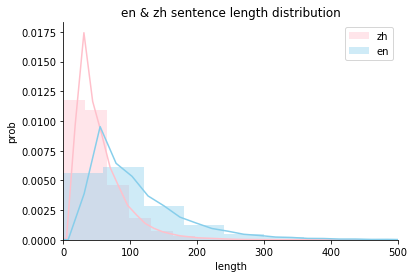

In [59]:
plt.close('all')
sns.distplot(zh_len,color='pink',label='zh')
sns.distplot(en_zh_len,color='skyblue',label='en')
plt.xlim([0,500])
plt.xlabel('length')
plt.ylabel('prob')
plt.legend()
plt.title('en & zh sentence length distribution')
sns.despine()
plt.show()

In [48]:
length_zh = sorted(en_zh_len)
MAX_LENGTH_ZH = en_zh_len[int(len(en_zh_len)*0.99)]
print(MAX_LENGTH_ZH)

91
